## Load and Clean the data

In [1]:
# load the data
red_wine <- read.csv('data/winequality-red.csv', sep = ';')
white_wine <- read.csv('data/winequality-white.csv', sep = ';')

# replace '.' with '_' in column names
names(red_wine) <- gsub('\\.', '_', names(red_wine))
names(white_wine) <- gsub('\\.', '_', names(white_wine))

# check the data
head(red_wine)
head(white_wine)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
2,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
3,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
5,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
6,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6


In [2]:
# add a column to indicate the type of wine
red_wine$type <- 'red'
white_wine$type <- 'white'

# merge the two dataframes
wine <- rbind(red_wine, white_wine)
head(wine)
print(dim(wine))

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


[1] 6497   13


In [3]:
# delete this chunk if unnecessary
# check for missing values
print(sum(is.na(wine)))

# convert the 'type' column to factor
wine$type <- as.factor(wine$type)
head(wine)

[1] 0


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


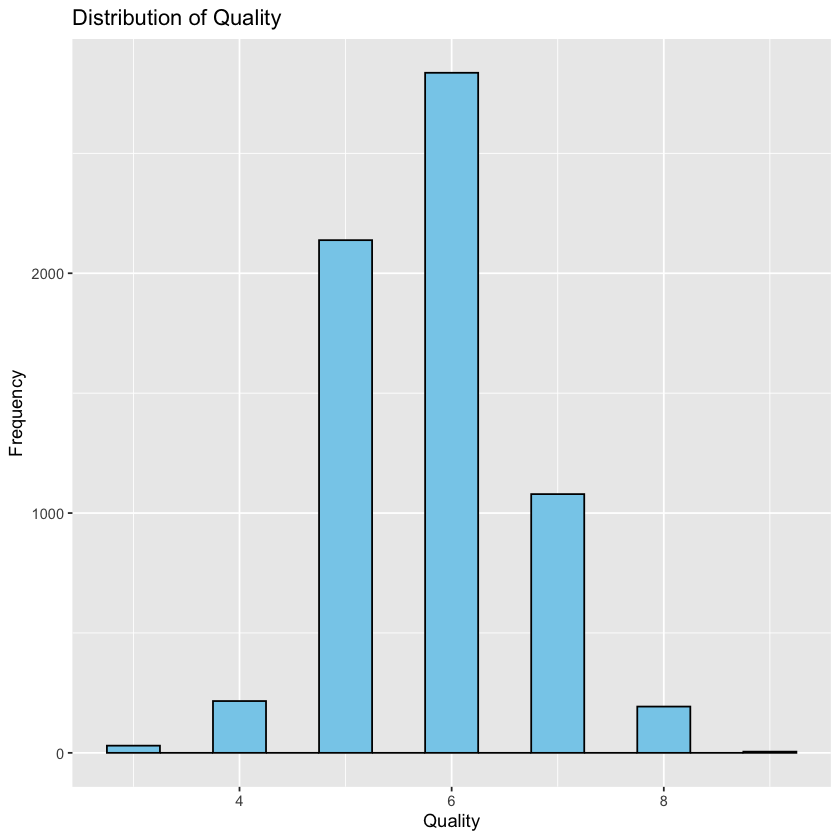

In [12]:
# plot out the distribution of the 'quality' column
library(ggplot2)

# plot histogram of quality distribution
ggplot(wine, aes(x = quality)) +
  geom_histogram(binwidth = 0.5, fill = "skyblue", color = "black") +
  labs(x = "Quality", y = "Frequency", title = "Distribution of Quality")

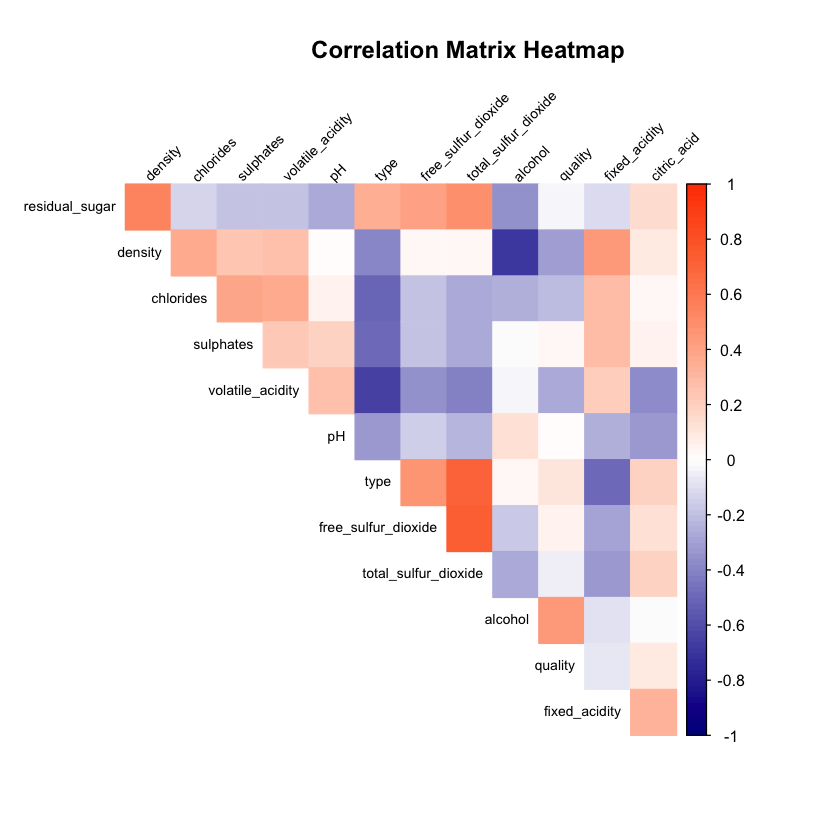

In [7]:
# import necessary libraries
library(dplyr)
library(reshape2)
library(corrplot)

wine <- wine %>%
  mutate(type = as.numeric(factor(type)))

# select numerical columns for correlation analysis
wine_num <- wine %>% select_if(is.numeric)

# calculate the correlation matrix
corr_matrix <- cor(wine_num)

# melt the correlation matrix for visualization
melted_correlation <- melt(corr_matrix)

# set up the plotting area
par(mar = c(6, 6, 4, 2) + 0.1)

# create a custom color palette
my_palette <- colorRampPalette(c("#00008B", "#FFFFFF", "#FF4500"))(100)

# plot the heatmaps
corrplot(corr_matrix, method = "color", col = my_palette, add = FALSE, order = "hclust",
         tl.col = "black", tl.srt = 45, diag = FALSE, type = "upper", tl.cex = 0.7)
title(main = "Correlation Matrix Heatmap")

## Linear Regression

In [8]:
# perform linear regression
lm_model <- lm(quality ~ ., data = wine)
summary(lm_model)


Call:
lm(formula = quality ~ ., data = wine)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7796 -0.4671 -0.0444  0.4561  3.0211 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.051e+02  1.417e+01   7.420 1.32e-13 ***
fixed_acidity         8.507e-02  1.576e-02   5.396 7.05e-08 ***
volatile_acidity     -1.492e+00  8.135e-02 -18.345  < 2e-16 ***
citric_acid          -6.262e-02  7.972e-02  -0.786   0.4322    
residual_sugar        6.244e-02  5.934e-03  10.522  < 2e-16 ***
chlorides            -7.573e-01  3.344e-01  -2.264   0.0236 *  
free_sulfur_dioxide   4.937e-03  7.662e-04   6.443 1.25e-10 ***
total_sulfur_dioxide -1.403e-03  3.237e-04  -4.333 1.49e-05 ***
density              -1.039e+02  1.434e+01  -7.248 4.71e-13 ***
pH                    4.988e-01  9.058e-02   5.506 3.81e-08 ***
sulphates             7.217e-01  7.624e-02   9.466  < 2e-16 ***
alcohol               2.227e-01  1.807e-02  12.320  < 2e-16 ***
type         

The summary above gives us an information that 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol' are the features that are important for the prediction of the quality of the wine.

Based on this information, we will perform logistic regression.

## Logistic Regression

In [10]:
# convert 'quality' column to binary variables
wine$quality_binary <- ifelse(wine$quality >= 7, 1, 0)

# perform logistic regression
logit_model <- glm(quality_binary ~ . - quality - type,
                   data = wine,
                   family = binomial)
summary(logit_model)


Call:
glm(formula = quality_binary ~ . - quality - type, family = binomial, 
    data = wine)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           2.829e+02  5.245e+01   5.394 6.91e-08 ***
fixed_acidity         4.382e-01  6.419e-02   6.826 8.74e-12 ***
volatile_acidity     -3.361e+00  3.741e-01  -8.986  < 2e-16 ***
citric_acid          -3.201e-01  3.450e-01  -0.928  0.35357    
residual_sugar        1.761e-01  2.192e-02   8.032 9.56e-16 ***
chlorides            -6.093e+00  2.333e+00  -2.612  0.00901 ** 
free_sulfur_dioxide   1.272e-02  2.890e-03   4.402 1.07e-05 ***
total_sulfur_dioxide -5.865e-03  1.158e-03  -5.067 4.05e-07 ***
density              -3.038e+02  5.350e+01  -5.677 1.37e-08 ***
pH                    2.387e+00  3.520e-01   6.781 1.20e-11 ***
sulphates             2.485e+00  2.848e-01   8.727  < 2e-16 ***
alcohol               5.791e-01  6.953e-02   8.329  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0

## Lasso Regression

Lasso Regression for red wine

In [ ]:
library(glmnet)
y <- red_wine$quality
x <- data.matrix(red_wine[, c('fixed_acidity','volatile_acidity',
'citric_acid','residual_sugar','chlorides','free_sulfur_dioxide',
'total_sulfur_dioxide','density','pH','sulphates','alcohol')])
cv_model <- cv.glmnet(x, y, alpha = 1)
best_lambda <- cv_model$lambda.min
best_lambda
plot(cv_model)

Choosing best model

In [ ]:
best_model <- glmnet(x, y, alpha = 1, lambda = best_lambda)
coef(best_model)

## Ridge Regression

## LDA

## QDA

## Neural Network